In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('JPM.csv')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-27,54.750000,55.430000,54.689999,55.139999,42.850201,14503700
1,2014-05-28,55.090000,55.599998,55.000000,55.450001,43.091106,11374900
2,2014-05-29,55.750000,55.919998,55.389999,55.720001,43.300938,11741000
3,2014-05-30,55.580002,55.880001,55.310001,55.570000,43.184361,11991900
4,2014-06-02,55.650002,55.650002,55.020000,55.349998,43.013397,9440000


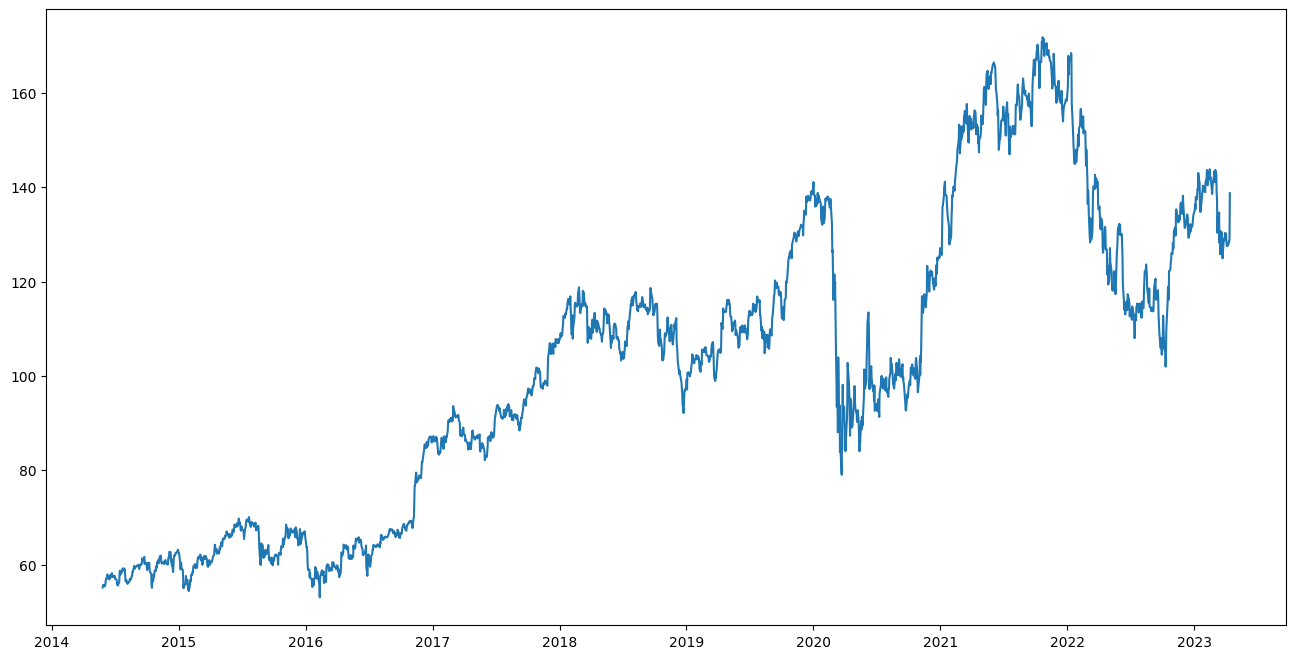

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

2178/2178 - 86s - loss: 0.0024 - 86s/epoch - 40ms/step
40/40 [==============================] - 2s 22ms/step


In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to compute the performance metrics
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


# Compute the performance metrics using the function above
mse, rmse, r2 = evaluate_performance(valid, closing_price)

# Print the results
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(rmse))
print("R2 Score: {:.4f}".format(r2))

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

MSE: 20.6340
RMSE: 4.5425
R2 Score: 0.9553


4.542469941892574

<ipython-input-5-8fdd2397322f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


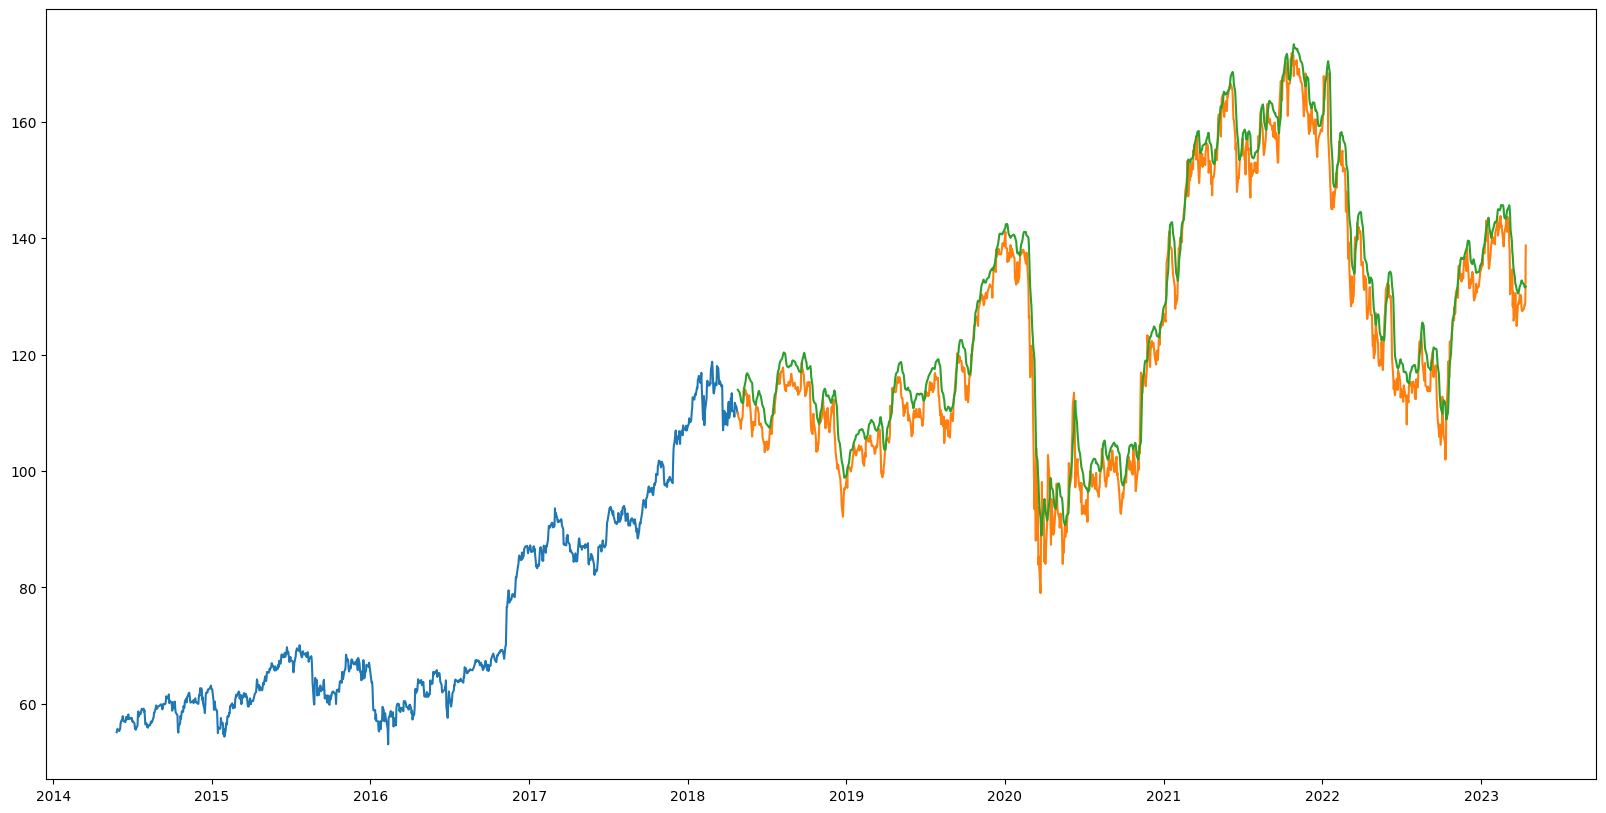

In [5]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [6]:
import datetime
from datetime import timedelta

now = datetime.datetime.now()

#print (valid.loc[valid.index.to_pydatetime() == now.strftime("%Y-%m-%d")])
#print(valid.loc['2019-05-24'])

In [7]:
cdif = valid.loc['2019-05-24'].Close-valid.loc['2019-05-23'].Close
pdif = valid.loc['2019-05-24'].Predictions-valid.loc['2019-05-23'].Predictions
den = valid.loc['2019-05-23'].Close
print (cdif)
print (pdif)

1.0699999999999932
-0.3700714


In [8]:
#cdif = valid.loc[valid.index.to_pydatetime() == (datetime.datetime.now() - timedelta(days=1))].Close - valid.loc[valid.index.to_pydatetime() == (datetime.datetime.now() - timedelta(days=2))].Close
#pdif = valid.loc['2019-05-24'].Predictions-valid.loc['2019-05-23'].Predictions
#print (cdif)
#print (pdif)

In [9]:
print (pdif/den)

-0.003406401091119418
